In [134]:
import torch
import torch.nn as nn
import torch.autograd as autograd

from modules.pinn_2d import *

import matplotlib.pyplot as plt


In [135]:
def make_tensor(x):
    return torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda()

In [136]:
x, y = np.mgrid[-1.0:1.02:0.02, -1.0:1.02:0.02]

In [137]:
fpath = './models/cpinn_2D_4.data'
state_dict = torch.load(fpath)

# Points
points_x = [-1.0, 1.0]
points_y = [-1.0, 1.0]

# Set the number of domains
domain_no = (len(points_x) + len(points_y)) // 2 - 1

# Set the global left & right boundary of the calculation domain
global_lb_x = -1.0
global_rb_x = 1.0
global_lb_y = -1.0
global_rb_y = 1.0

# Initialize CPINN model
model = CPINN_2D(domain_no, global_lb_x, global_rb_x, global_lb_y, global_rb_y, figure_path=None)

# to do
model.make_domains(points_x, points_y)

sample = {'Model{}'.format(i+1): PINN(i) for i in range(domain_no)}

model.module_update(sample)

model.load_state_dict(state_dict)

model = model.cuda()

In [138]:
xy = torch.from_numpy(np.vstack((x.flatten(), y.flatten()))).type(torch.FloatTensor)
pred = model(xy[0].unsqueeze(0).T.cuda(), xy[1].unsqueeze(0).T.cuda())

Predict by model - X disp.

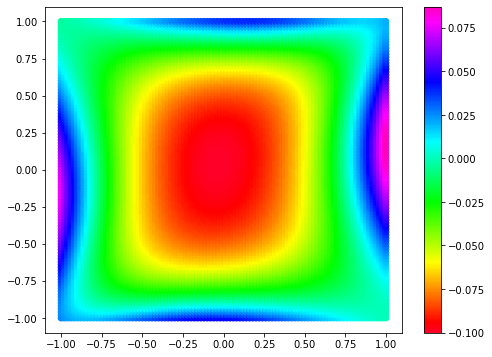

In [139]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=pred[:,0].cpu().detach().numpy(), cmap='gist_rainbow')
plt.colorbar()
plt.savefig("./data/2D_plate_1_u_model.png")

Predict by model - Y disp.

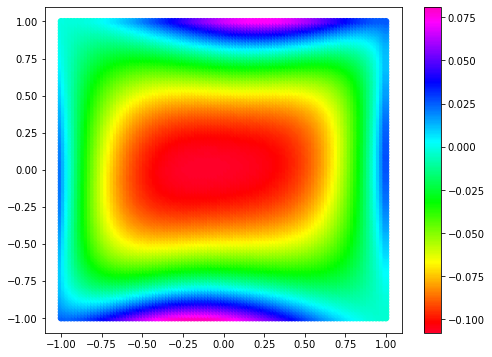

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=pred[:,1].cpu().detach().numpy(), cmap='gist_rainbow')
plt.colorbar()
plt.savefig("./data/2D_plate_1_v_model.png")

FEM Result

In [131]:
fname = "./data/2D_plate_1.txt"
data = np.loadtxt(fname=fname)

x, y, u, v = data.T

Predict by FEM - X disp.

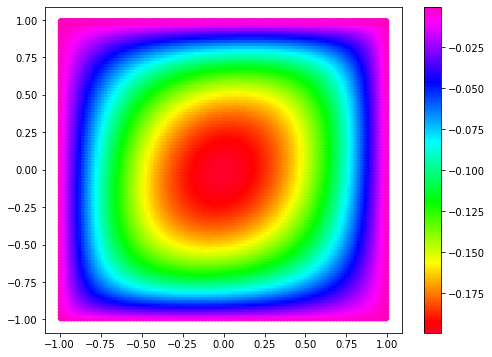

In [132]:
plt.figure(figsize=(8, 6))

plt.scatter(x, y, c=u, cmap='gist_rainbow')
plt.colorbar()

plt.savefig("./data/2D_plate_1_u_fem.png")

Predict by FEM - Y disp.

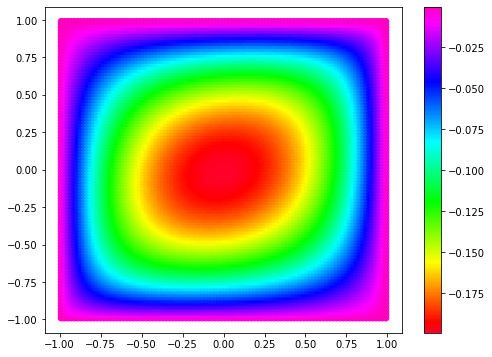

In [133]:
plt.figure(figsize=(8, 6))

plt.scatter(x, y, c=v, cmap='gist_rainbow')
plt.colorbar()
plt.savefig("./data/2D_plate_1_v_fem.png")